<h1>Softmax Regression on MNIST</h1>

<h3>Imports</h3>

In [195]:
import torch
import time
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


In [196]:
# setting the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<h3>Preprocessing the data</h3>

In [197]:
# normalizing the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


<h3>Downloading the dataset</h3>

In [198]:
train_val_dataset = datasets.MNIST(root='./dataset', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='./dataset', train=False, download=False, transform=transform)
combined_dataset = ConcatDataset([train_val_dataset, test_dataset])


In [199]:
print(f"Train dataset size: {len(train_val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Combined dataset size: {len(combined_dataset)}")

Train dataset size: 60000
Test dataset size: 10000
Combined dataset size: 70000


<h3>HyperParameters</h3>

In [200]:
batch_size = 64   # change between 32, 64, 128, 256
num_classes = 10
input_size = 28 * 28
num_epochs = 20
l2_lambda = 0.0001

<h3>Splitting the data</h3>

In [201]:
# calculating split sizes
train_datset_size = int(0.6 * len(combined_dataset))
val_dataset_size = int(0.2 * len(combined_dataset))
test_dataset_size = len(combined_dataset) - train_datset_size - val_dataset_size

# printing split sizes
print(train_datset_size, val_dataset_size, test_dataset_size)

42000 14000 14000


In [202]:
# splitting the dataset
train_dataset_idx, temp_dataset_idx = train_test_split(list(range(len(combined_dataset))), train_size=train_datset_size, random_state=5, stratify=True) 
val_dataset_idx, test_dataset_idx = train_test_split(temp_dataset_idx, test_size=0.5, random_state=5, stratify=True)

print(len(train_dataset_idx), len(val_dataset_idx), len(test_dataset_idx))

42000 14000 14000


In [203]:
# make subset of the dataset based on the split indices
train_dataset = Subset(combined_dataset, train_dataset_idx)
val_dataset = Subset(combined_dataset, val_dataset_idx)
test_dataset = Subset(combined_dataset, test_dataset_idx)

print(len(train_dataset), len(val_dataset), len(test_dataset))

42000 14000 14000


In [204]:
# creating dataloaders
train_dataset_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataset_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_dataset_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print(len(train_dataset_loader), len(val_dataset_loader), len(test_dataset_loader))

657 219 219


In [205]:
x, y = next(iter(train_dataset_loader))

print(x.shape)  # [batch_size, channels, height, width]
print(y.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


<h2>Softmax Regression Model</h2>

<h3>1. Define the softmax regression model</h3>

- Define the main layer, this is the main layer of the softmax regression model, which computes (Wx+b)
- MNIST images are 28x28 pixels, 10 classes
```
self.linear = torch.nn.Linear(input_size, num_classes)
```
- The forward pass that defines how the input data flows through the model

In [206]:
class SoftmaxRegressionModel(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxRegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(input_size, num_classes)

    def forward(self, x): # x is the input = image
        x = x.view(x.size(0), -1)  # Flatten the images from (batch_size, 1, 28, 28) to (batch_size, 784), express each example with a vector(784) instead of matrix 28*28
        return self.linear(x)   # softmax is applied in the cross entropy loss (criterion)

<h3>2. Training the Model</h3>

**First: Initialize model, loss function, and optimizer:**
- Model: Softmax Regression <br/>
- Loss Function: Cross-Entropy <br/>
- Optimizer: Stochastic Gradient Descent (SGD) <br/>

- Training Loop: <br/>
```
for epoch in range(num_epochs):
    model.train()
```

- **y_train** is the ground truth label for the current batch
- **outputs** is the predicted label for the current batch

- clear the gradients of all optimized variables to prevent accumulation of gradients from previous batches ``` optimizer.zero_grad() ```

- forward pass of the model on the current batch ``` outputs = model(x_train) ```

- compute the loss between the predicted label (outputs) and the ground truth label (y_train) ``` loss = criterion(outputs, y_train) ```
<hr/>

**Compute Gradients:**

- compute the gradients of the loss with respect to the model parameters ``` loss.backward() ```
- update the model parameters based on the computed gradients ``` optimizer.step() ```

<hr/>

<h3>3. Evaluating the model on Validation Dataset</h3>

**"The validation results are used to tune hyperparameters and select the best model based on its performance on the validation dataset."**

- **Model Evaluation**: Set the model to evaluation mode using `model.eval()`. This ensures that layers like dropout and batch normalization behave appropriately during validation.
- **Loss Calculation**: Compute the loss on the validation dataset using the same loss function as used for training.
- **Accuracy Calculation**: Calculate the accuracy by comparing the predicted labels with the true labels.
- **No Gradient Calculation**: Use `torch.no_grad()` to disable gradient calculation, which reduces memory consumption and speeds up computation during validation.
- **Performance Monitoring**: Track the validation loss and accuracy for each epoch to monitor the model's performance over time.

<hr/>

<h3>4. Evaluating the model on Test Dataset</h3>

**"After training and validating the model, we evaluate its performance on the test dataset. This helps us understand how well the model generalizes to unseen data."**

- **Model Evaluation**: Set the model to evaluation mode using `model.eval()`. This ensures that layers like dropout and batch normalization behave appropriately during testing.\n",
- **No Gradient Calculation**: Use `torch.no_grad()` to disable gradient calculation, which reduces memory consumption and speeds up computation during testing.
- **Prediction**: Pass the test data through the model to obtain predictions.
- **Accuracy Calculation**: Calculate the accuracy by comparing the predicted labels with the true labels. 
``accuracy = accuracy_score(y_true, y_pred) ``

<hr/>

<h3>5. Confusion Matrix for the Test Dataset Predictions</h3>

**"A confusion matrix is a useful tool for evaluating the performance of a classification model. It provides a detailed breakdown of the model's predictions compared to the actual labels. The confusion matrix helps in understanding the types of errors the model is making and which classes are being misclassified."**

- **Generate Confusion Matrix**: Calculate the confusion matrix using the true labels and the predicted labels. This matrix shows the counts of true positive, true negative, false positive, and false negative predictions for each class.
- **Visualization**: Visualize the confusion matrix using a heatmap to make it easier to interpret. The heatmap provides a color-coded representation of the matrix, where the intensity of the color represents the count of predictions.


<hr/>

<h3>6. Visualization & Plotting</h3>

**"Visualization and plotting are essential for understanding the performance of the model during training and evaluation. They help in identifying trends, patterns, and potential issues, helping to make informed decisions about model tuning and improvements."**

- **Training and Validation Loss**: Plot the training and validation loss over epochs to monitor the model's learning process. This helps in identifying issues like overfitting or underfitting.
- **Training and Validation Accuracy**: Plot the training and validation accuracy over epochs to evaluate the model's performance. This helps in understanding how well the model is generalizing to the validation data.
- **Learning Rate Comparison**: Plot the training and validation metrics for different learning rates to compare their performance. This helps in identifying the best learning rate for the model.




Learning rate: 0.1 without L2 regularization
Epoch 1/20
Epoch 1/20 Training Loss: 0.7679
Epoch 1/20 Training Accuracy: 83.00%
Epoch 1/20 Validation Loss: 0.7383
Epoch 1/20 Validation Accuracy: 80.29%
--------------------------------------------------
Epoch 2/20
Epoch 2/20 Training Loss: 0.3827
Epoch 2/20 Training Accuracy: 88.68%
Epoch 2/20 Validation Loss: 0.4479
Epoch 2/20 Validation Accuracy: 86.56%
--------------------------------------------------
Epoch 3/20
Epoch 3/20 Training Loss: 0.3611
Epoch 3/20 Training Accuracy: 89.48%
Epoch 3/20 Validation Loss: 0.4222
Epoch 3/20 Validation Accuracy: 87.54%
--------------------------------------------------
Epoch 4/20
Epoch 4/20 Training Loss: 0.3450
Epoch 4/20 Training Accuracy: 89.81%
Epoch 4/20 Validation Loss: 0.5699
Epoch 4/20 Validation Accuracy: 84.93%
--------------------------------------------------
Epoch 5/20
Epoch 5/20 Training Loss: 0.3333
Epoch 5/20 Training Accuracy: 90.17%
Epoch 5/20 Validation Loss: 0.3400
Epoch 5/20 Vali

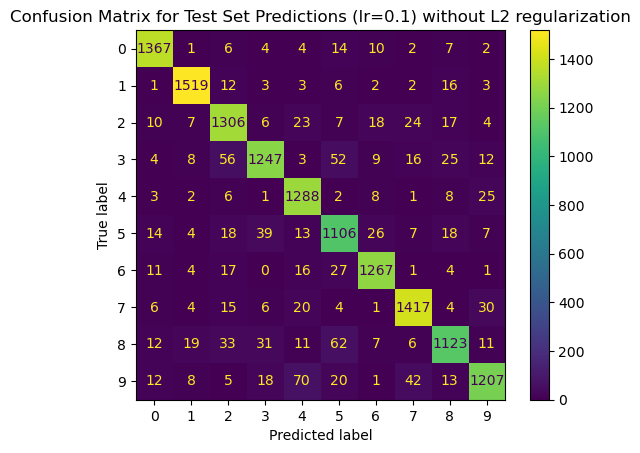

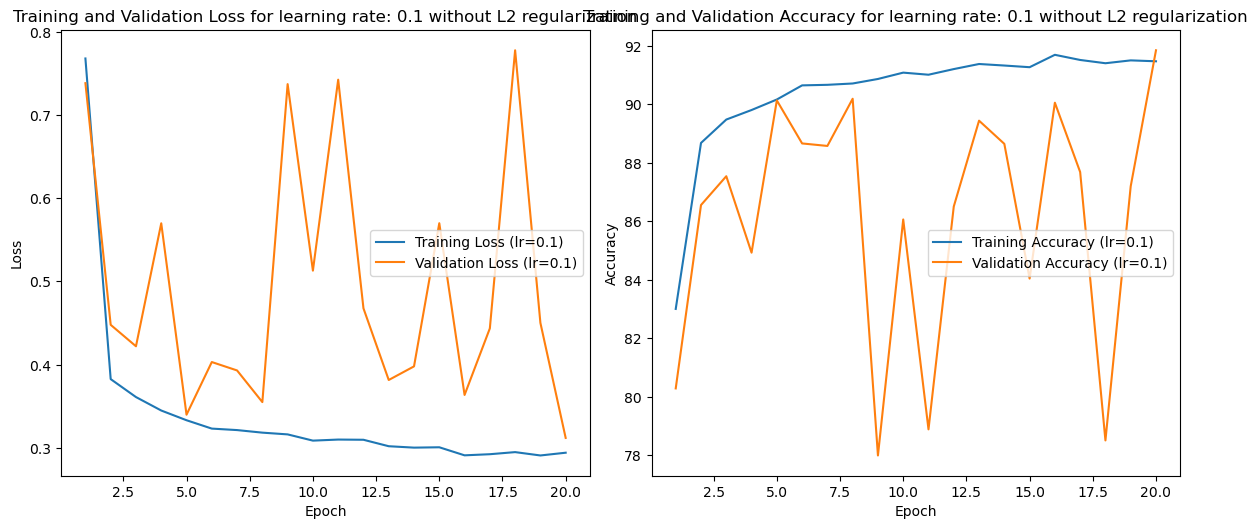

Learning rate: 0.01 without L2 regularization
Epoch 1/20
Epoch 1/20 Training Loss: 0.6857
Epoch 1/20 Training Accuracy: 82.65%
Epoch 1/20 Validation Loss: 0.4544
Epoch 1/20 Validation Accuracy: 87.97%
--------------------------------------------------
Epoch 2/20
Epoch 2/20 Training Loss: 0.4122
Epoch 2/20 Training Accuracy: 88.66%
Epoch 2/20 Validation Loss: 0.3847
Epoch 2/20 Validation Accuracy: 89.27%
--------------------------------------------------
Epoch 3/20
Epoch 3/20 Training Loss: 0.3693
Epoch 3/20 Training Accuracy: 89.70%
Epoch 3/20 Validation Loss: 0.3649
Epoch 3/20 Validation Accuracy: 89.68%
--------------------------------------------------
Epoch 4/20
Epoch 4/20 Training Loss: 0.3478
Epoch 4/20 Training Accuracy: 90.17%
Epoch 4/20 Validation Loss: 0.3479
Epoch 4/20 Validation Accuracy: 90.30%
--------------------------------------------------
Epoch 5/20
Epoch 5/20 Training Loss: 0.3337
Epoch 5/20 Training Accuracy: 90.52%
Epoch 5/20 Validation Loss: 0.3348
Epoch 5/20 Val

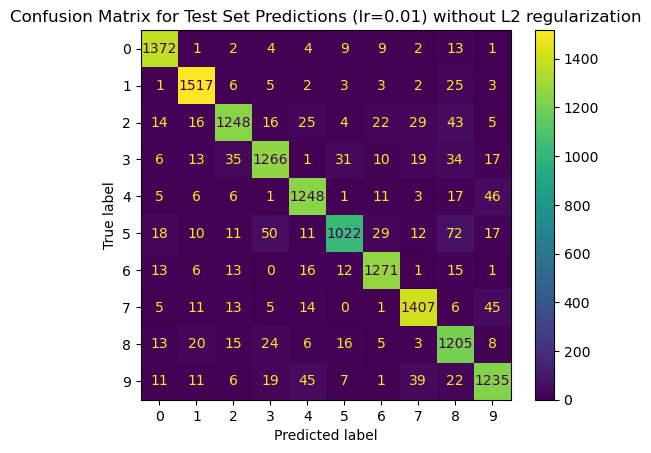

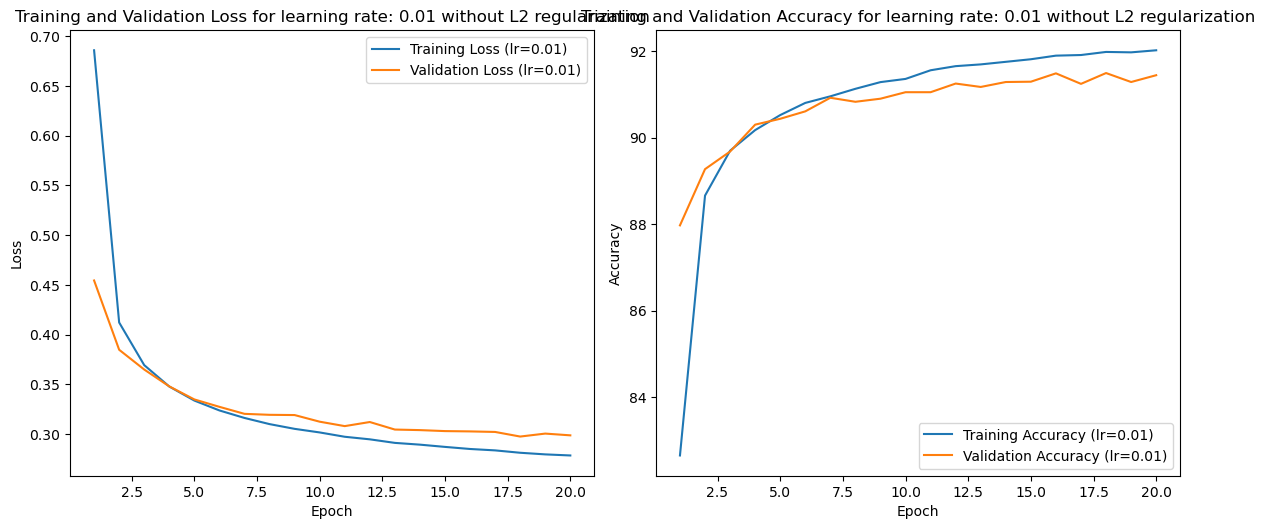

Learning rate: 0.001 without L2 regularization
Epoch 1/20
Epoch 1/20 Training Loss: 1.5034
Epoch 1/20 Training Accuracy: 63.84%
Epoch 1/20 Validation Loss: 1.0554
Epoch 1/20 Validation Accuracy: 79.99%
--------------------------------------------------
Epoch 2/20
Epoch 2/20 Training Loss: 0.8887
Epoch 2/20 Training Accuracy: 81.81%
Epoch 2/20 Validation Loss: 0.7742
Epoch 2/20 Validation Accuracy: 83.69%
--------------------------------------------------
Epoch 3/20
Epoch 3/20 Training Loss: 0.7066
Epoch 3/20 Training Accuracy: 84.31%
Epoch 3/20 Validation Loss: 0.6543
Epoch 3/20 Validation Accuracy: 85.34%
--------------------------------------------------
Epoch 4/20
Epoch 4/20 Training Loss: 0.6183
Epoch 4/20 Training Accuracy: 85.57%
Epoch 4/20 Validation Loss: 0.5877
Epoch 4/20 Validation Accuracy: 86.44%
--------------------------------------------------
Epoch 5/20
Epoch 5/20 Training Loss: 0.5642
Epoch 5/20 Training Accuracy: 86.38%
Epoch 5/20 Validation Loss: 0.5433
Epoch 5/20 Va

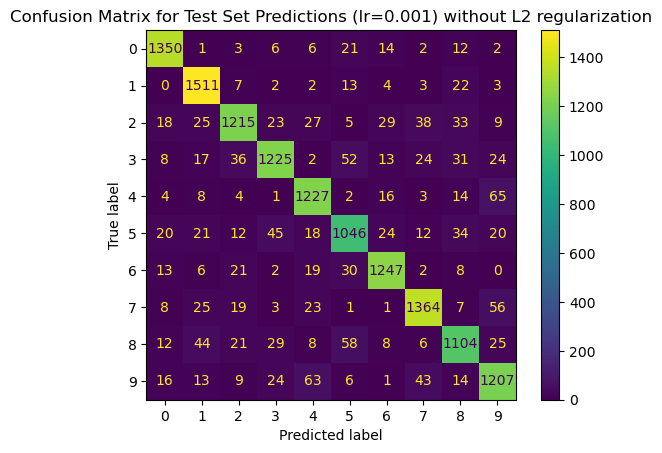

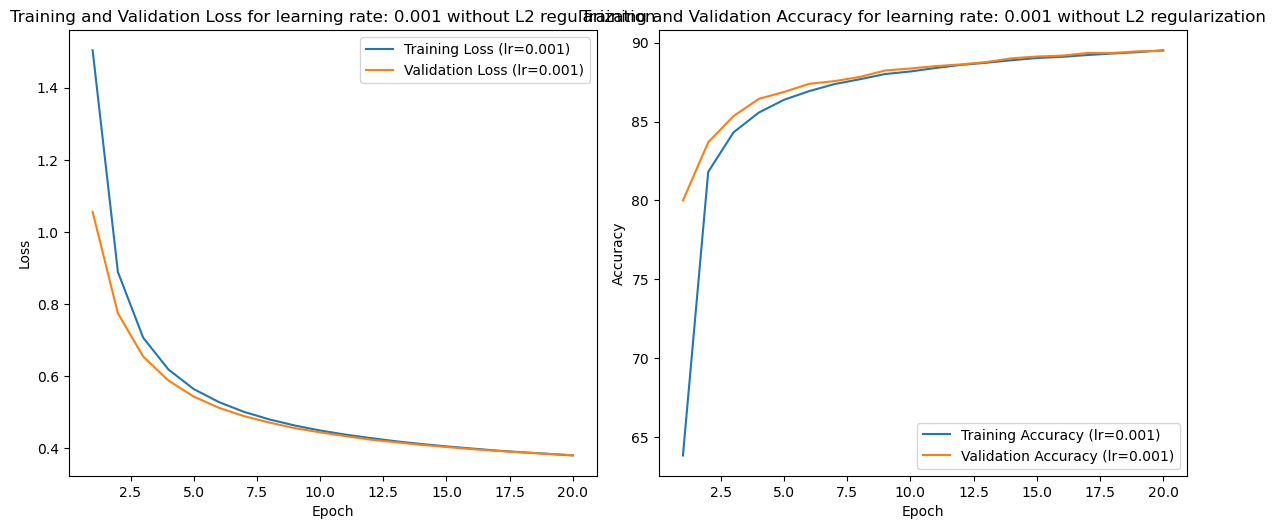

Learning rate: 0.0001 without L2 regularization
Epoch 1/20
Epoch 1/20 Training Loss: 2.2288
Epoch 1/20 Training Accuracy: 19.54%
Epoch 1/20 Validation Loss: 2.0795
Epoch 1/20 Validation Accuracy: 34.31%
--------------------------------------------------
Epoch 2/20
Epoch 2/20 Training Loss: 1.9649
Epoch 2/20 Training Accuracy: 44.28%
Epoch 2/20 Validation Loss: 1.8584
Epoch 2/20 Validation Accuracy: 53.12%
--------------------------------------------------
Epoch 3/20
Epoch 3/20 Training Loss: 1.7634
Epoch 3/20 Training Accuracy: 58.74%
Epoch 3/20 Validation Loss: 1.6778
Epoch 3/20 Validation Accuracy: 63.19%
--------------------------------------------------
Epoch 4/20
Epoch 4/20 Training Loss: 1.5992
Epoch 4/20 Training Accuracy: 66.58%
Epoch 4/20 Validation Loss: 1.5302
Epoch 4/20 Validation Accuracy: 68.94%
--------------------------------------------------
Epoch 5/20
Epoch 5/20 Training Loss: 1.4653
Epoch 5/20 Training Accuracy: 70.98%
Epoch 5/20 Validation Loss: 1.4092
Epoch 5/20 V

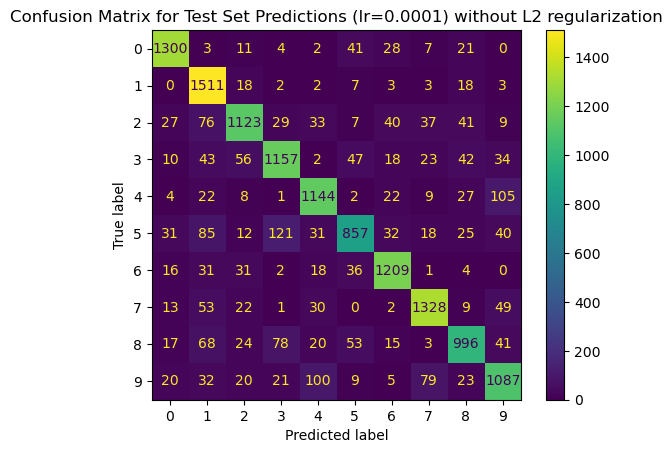

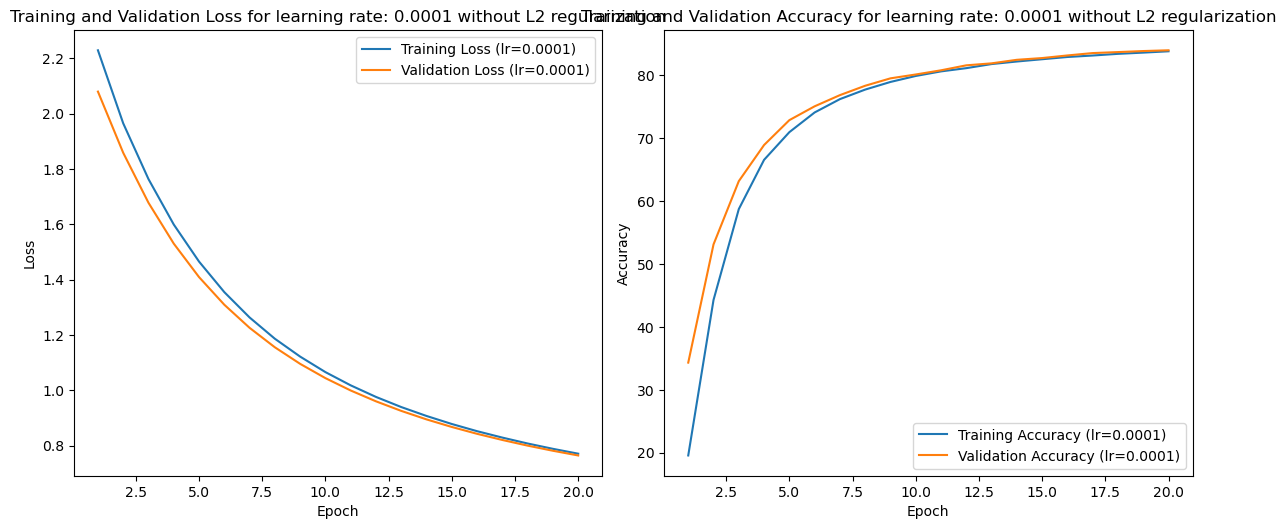

In [207]:
dict = {}
results = {}
for lr in [0.1, 0.01, 0.001, 0.0001]:
    print(f"Learning rate: {lr} without L2 regularization")
    model = SoftmaxRegressionModel(input_size, num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    
    start = time.time()

    for epoch in range(num_epochs):     # loop over the dataset num_epochs times
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        epoch_train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (x_train, y_train) in enumerate(train_dataset_loader):
            x_train, y_train = x_train.to(device), y_train.to(device)
            
            # outputs = logits = values before softmax, with shape (batch_size, num_classes)
            outputs = model(x_train)
            batch_train_loss = criterion(outputs, y_train)
            
            # calculate the gradients
            predicted = torch.argmax(outputs, dim=1)
            train_total += y_train.size(0)
            train_correct += (predicted == y_train).sum().item()
            optimizer.zero_grad()  # clear the gradients
            batch_train_loss.backward()     # dl/dwi
            optimizer.step()  # update weights, W = W - lr * gradient
            epoch_train_loss += batch_train_loss.item()   # update loss of current epoch with loss for current batch
            
        # calculate the average loss and accuracy for the current epoch
        epoch_train_loss /= len(train_dataset_loader)
        train_losses.append(epoch_train_loss)
        train_accuracy = 100 * (train_correct / train_total)
        train_accuracies.append(train_accuracy)
        
        # Validation loop
        model.eval()
        epoch_val_loss = 0.0
        val_correct = 0
        val_total = 0 # total number of examples in the dataset
        
        with torch.no_grad():
            for x_val, y_val in val_dataset_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                outputs = model(x_val) # logits
                batch_val_loss = criterion(outputs, y_val) 
                epoch_val_loss += batch_val_loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += y_val.size(0)
                val_correct += (predicted == y_val).sum().item()

        epoch_val_loss /= len(val_dataset_loader)
        val_losses.append(epoch_val_loss)
        val_accuracy = 100 * (val_correct / val_total)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs} Training Loss: {epoch_train_loss:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs} Training Accuracy: {train_accuracy:.2f}%")
        print(f"Epoch {epoch+1}/{num_epochs} Validation Loss: {epoch_val_loss:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs} Validation Accuracy: {val_accuracy:.2f}%")
        print("-" * 50)
    
    end = time.time()
    total_duration = end - start
    print(f"Training time for learning rate {lr}: {total_duration:.2f} seconds without L2 regularization")

    # store the training and validation results for the current learning rate
    dict[lr] = (epoch_train_loss, train_accuracy, epoch_val_loss, val_accuracy)
    results[lr] = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'total_duration': total_duration
    }
    
    # Evaluate the model on the test dataset
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for x_test, y_test in test_dataset_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            outputs = model(x_test)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_test.cpu().numpy()) # convert to numpy array from tensor
            y_pred.extend(predicted.cpu().numpy())
    
    # calculate the test accuracy
    accuracy = accuracy_score(y_true, y_pred)
    results[lr]['test_accuracy'] = accuracy * 100
    print(f"Test Accuracy: {accuracy * 100:.2f}% for learning rate: {lr} without L2 regularization")
    print("-" * 50)
    
    print("Results Summary for learning rate: ", lr, " without L2 regularization")
    print(f"Training Loss: {dict[lr][0]: .4f}")
    print(f"Training Accuracy: {dict[lr][1]: .4f}%")
    print(f"Validation Loss: {dict[lr][2]: .4f}")
    print(f"Validation Accuracy: {dict[lr][3]: .4f}%")
    print(f"Test Accuracy: {results[lr]['test_accuracy']:.2f}%")
    print(f"Total Training Time: {results[lr]['total_duration']:.2f} seconds")
    print("-" * 50)
    
    # plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)))
    disp.plot(cmap='viridis', values_format='d')
    plt.title(f"Confusion Matrix for Test Set Predictions (lr={lr}) without L2 regularization")
    plt.show()
    
    
    # plot the training and validation loss & accuracy for the current learning rate
    plt.figure(figsize=(12, 10))
    epochs = range(1, num_epochs + 1)
    
    # plot training and validation loss
    plt.subplot(2, 2, 1)
    plt.title(f"Training and Validation Loss for learning rate: {lr} without L2 regularization")
    plt.plot(epochs, results[lr]['train_losses'], label=f'Training Loss (lr={lr})')
    plt.plot(epochs, results[lr]['val_losses'], label=f'Validation Loss (lr={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # plot training and validation accuracy
    plt.subplot(2, 2, 2)
    plt.title(f"Training and Validation Accuracy for learning rate: {lr } without L2 regularization")
    plt.plot(epochs, results[lr]['train_accuracies'], label=f'Training Accuracy (lr={lr})')
    plt.plot(epochs, results[lr]['val_accuracies'], label=f'Validation Accuracy (lr={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

<h2>Results Summary without L2 Regularization</h2>

In [208]:
print("Final Results for all learning rates without L2 Reqularization:")
for lr in [0.1, 0.01, 0.001, 0.0001]:
    print(f"learning_rate = {lr}")
    print(f"Training Loss: {dict[lr][0]: .4f}")
    print(f"Training Accuracy: {dict[lr][1]: .4f}%")
    print(f"Validation Loss: {dict[lr][2]: .4f}")
    print(f"Validation Accuracy: {dict[lr][3]: .4f}%")
    print(f"Test Accuracy: {results[lr]['test_accuracy']:.2f}%")
    print(f"Total Training Time: {results[lr]['total_duration']:.2f} seconds")

    print("-" * 50)

Final Results for all learning rates without L2 Reqularization:
learning_rate = 0.1
Training Loss:  0.2943
Training Accuracy:  91.4738%
Validation Loss:  0.3121
Validation Accuracy:  91.8500%
Test Accuracy: 91.76%
Total Training Time: 192.26 seconds
--------------------------------------------------
learning_rate = 0.01
Training Loss:  0.2785
Training Accuracy:  92.0190%
Validation Loss:  0.2987
Validation Accuracy:  91.4429%
Test Accuracy: 91.36%
Total Training Time: 181.55 seconds
--------------------------------------------------
learning_rate = 0.001
Training Loss:  0.3800
Training Accuracy:  89.5167%
Validation Loss:  0.3807
Validation Accuracy:  89.4786%
Test Accuracy: 89.26%
Total Training Time: 192.74 seconds
--------------------------------------------------
learning_rate = 0.0001
Training Loss:  0.7711
Training Accuracy:  83.8476%
Validation Loss:  0.7647
Validation Accuracy:  84.0071%
Test Accuracy: 83.66%
Total Training Time: 154.13 seconds
---------------------------------

<h2>Best Learning Rate without L2 Regularization</h2>

In [209]:
# Find the best learning rate based on the test accuracy
best_lr = None
best_accuracy = 0

for lr in results.keys():
    if results[lr]['test_accuracy'] > best_accuracy:
        best_accuracy = results[lr]['test_accuracy']
        best_lr = lr

print(f"Best Learning Rate: {best_lr} with Test Accuracy: {best_accuracy:.2f}% without L2 regularization")

Best Learning Rate: 0.1 with Test Accuracy: 91.76% without L2 regularization


<h2>Adding L2 Regularization</h2>

with lambda = 0.0001

Learning rate: 0.1 with L2 regularization
Epoch 1/20
Epoch 1/20 Training Loss: 0.7708
Epoch 1/20 Training Accuracy: 82.97%
Epoch 1/20 Validation Loss: 0.4318
Epoch 1/20 Validation Accuracy: 87.78%
--------------------------------------------------
Epoch 2/20
Epoch 2/20 Training Loss: 0.3833
Epoch 2/20 Training Accuracy: 88.68%
Epoch 2/20 Validation Loss: 0.7120
Epoch 2/20 Validation Accuracy: 81.71%
--------------------------------------------------
Epoch 3/20
Epoch 3/20 Training Loss: 0.3630
Epoch 3/20 Training Accuracy: 89.44%
Epoch 3/20 Validation Loss: 0.4553
Epoch 3/20 Validation Accuracy: 86.41%
--------------------------------------------------
Epoch 4/20
Epoch 4/20 Training Loss: 0.3461
Epoch 4/20 Training Accuracy: 89.89%
Epoch 4/20 Validation Loss: 0.4359
Epoch 4/20 Validation Accuracy: 87.14%
--------------------------------------------------
Epoch 5/20
Epoch 5/20 Training Loss: 0.3312
Epoch 5/20 Training Accuracy: 90.41%
Epoch 5/20 Validation Loss: 0.6112
Epoch 5/20 Validat

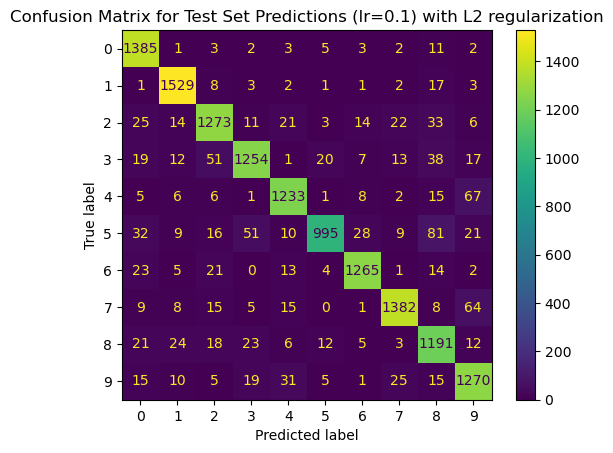

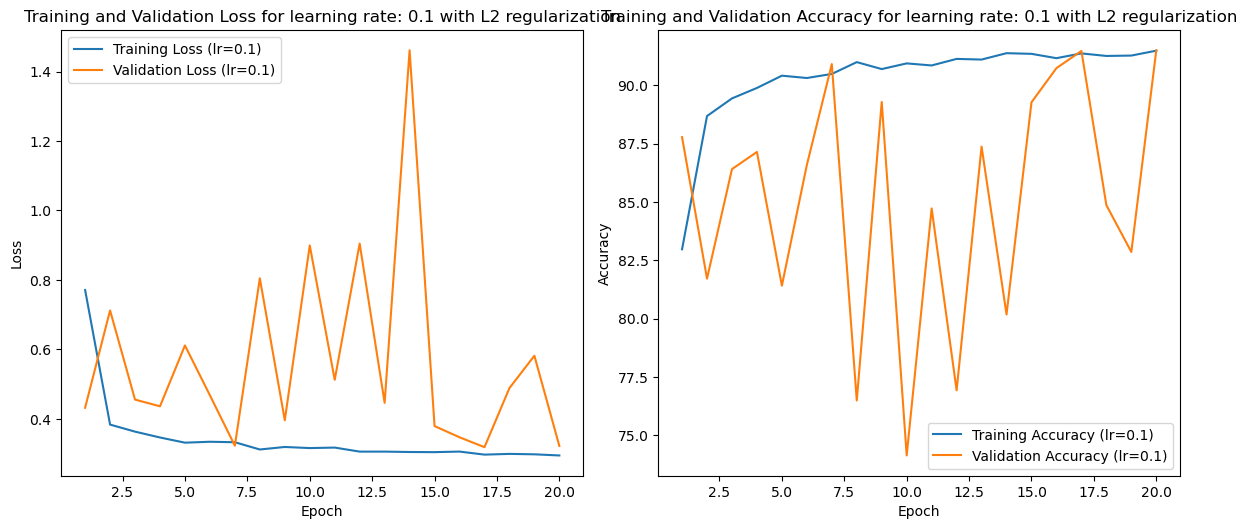

Learning rate: 0.01 with L2 regularization
Epoch 1/20
Epoch 1/20 Training Loss: 0.6814
Epoch 1/20 Training Accuracy: 83.17%
Epoch 1/20 Validation Loss: 0.4559
Epoch 1/20 Validation Accuracy: 87.76%
--------------------------------------------------
Epoch 2/20
Epoch 2/20 Training Loss: 0.4105
Epoch 2/20 Training Accuracy: 88.78%
Epoch 2/20 Validation Loss: 0.3884
Epoch 2/20 Validation Accuracy: 89.41%
--------------------------------------------------
Epoch 3/20
Epoch 3/20 Training Loss: 0.3682
Epoch 3/20 Training Accuracy: 89.76%
Epoch 3/20 Validation Loss: 0.3599
Epoch 3/20 Validation Accuracy: 89.69%
--------------------------------------------------
Epoch 4/20
Epoch 4/20 Training Loss: 0.3467
Epoch 4/20 Training Accuracy: 90.22%
Epoch 4/20 Validation Loss: 0.3457
Epoch 4/20 Validation Accuracy: 90.22%
--------------------------------------------------
Epoch 5/20
Epoch 5/20 Training Loss: 0.3331
Epoch 5/20 Training Accuracy: 90.54%
Epoch 5/20 Validation Loss: 0.3344
Epoch 5/20 Valida

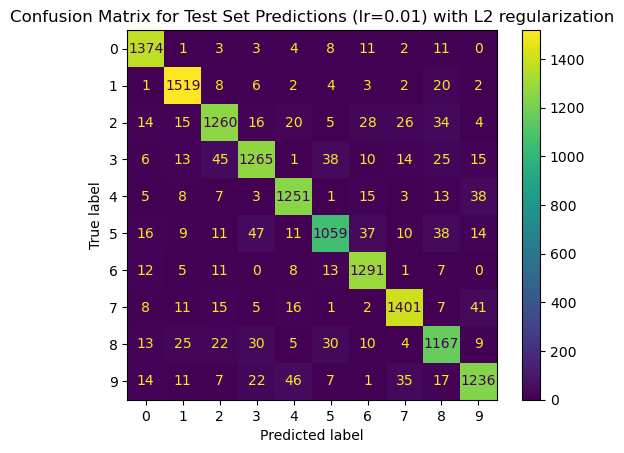

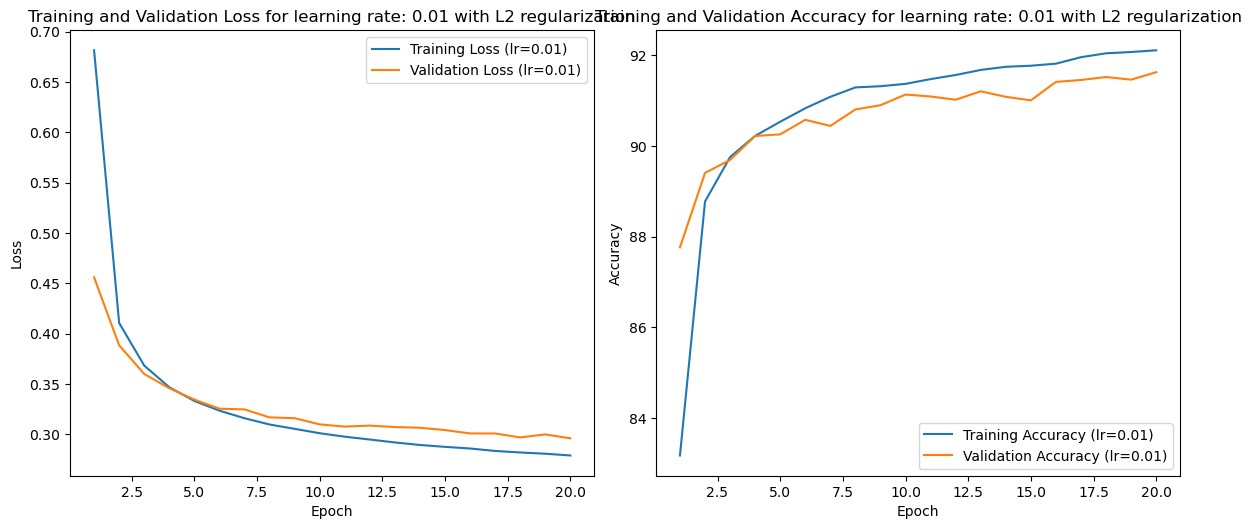

Learning rate: 0.001 with L2 regularization
Epoch 1/20
Epoch 1/20 Training Loss: 1.4879
Epoch 1/20 Training Accuracy: 65.48%
Epoch 1/20 Validation Loss: 1.0458
Epoch 1/20 Validation Accuracy: 80.44%
--------------------------------------------------
Epoch 2/20
Epoch 2/20 Training Loss: 0.8806
Epoch 2/20 Training Accuracy: 82.13%
Epoch 2/20 Validation Loss: 0.7679
Epoch 2/20 Validation Accuracy: 83.80%
--------------------------------------------------
Epoch 3/20
Epoch 3/20 Training Loss: 0.7028
Epoch 3/20 Training Accuracy: 84.43%
Epoch 3/20 Validation Loss: 0.6510
Epoch 3/20 Validation Accuracy: 85.34%
--------------------------------------------------
Epoch 4/20
Epoch 4/20 Training Loss: 0.6161
Epoch 4/20 Training Accuracy: 85.62%
Epoch 4/20 Validation Loss: 0.5855
Epoch 4/20 Validation Accuracy: 86.38%
--------------------------------------------------
Epoch 5/20
Epoch 5/20 Training Loss: 0.5634
Epoch 5/20 Training Accuracy: 86.42%
Epoch 5/20 Validation Loss: 0.5430
Epoch 5/20 Valid

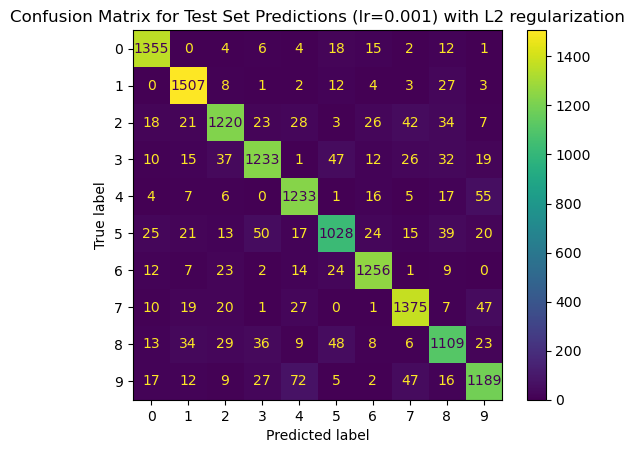

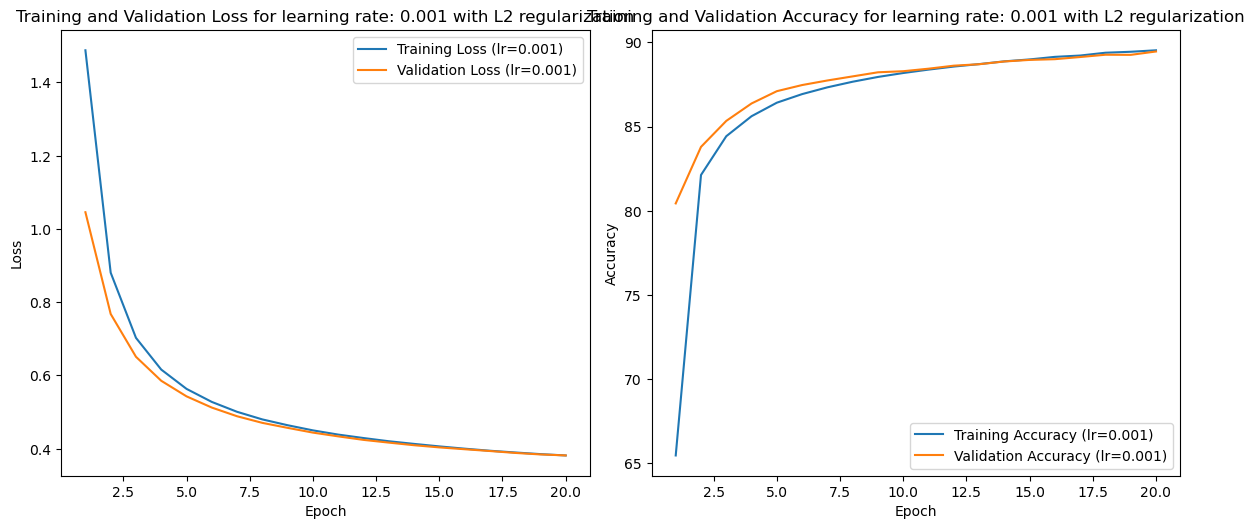

Learning rate: 0.0001 with L2 regularization
Epoch 1/20
Epoch 1/20 Training Loss: 2.2734
Epoch 1/20 Training Accuracy: 17.44%
Epoch 1/20 Validation Loss: 2.1271
Epoch 1/20 Validation Accuracy: 29.48%
--------------------------------------------------
Epoch 2/20
Epoch 2/20 Training Loss: 2.0085
Epoch 2/20 Training Accuracy: 39.82%
Epoch 2/20 Validation Loss: 1.9035
Epoch 2/20 Validation Accuracy: 48.03%
--------------------------------------------------
Epoch 3/20
Epoch 3/20 Training Loss: 1.8049
Epoch 3/20 Training Accuracy: 54.39%
Epoch 3/20 Validation Loss: 1.7203
Epoch 3/20 Validation Accuracy: 59.35%
--------------------------------------------------
Epoch 4/20
Epoch 4/20 Training Loss: 1.6385
Epoch 4/20 Training Accuracy: 63.40%
Epoch 4/20 Validation Loss: 1.5707
Epoch 4/20 Validation Accuracy: 66.14%
--------------------------------------------------
Epoch 5/20
Epoch 5/20 Training Loss: 1.5023
Epoch 5/20 Training Accuracy: 68.55%
Epoch 5/20 Validation Loss: 1.4479
Epoch 5/20 Vali

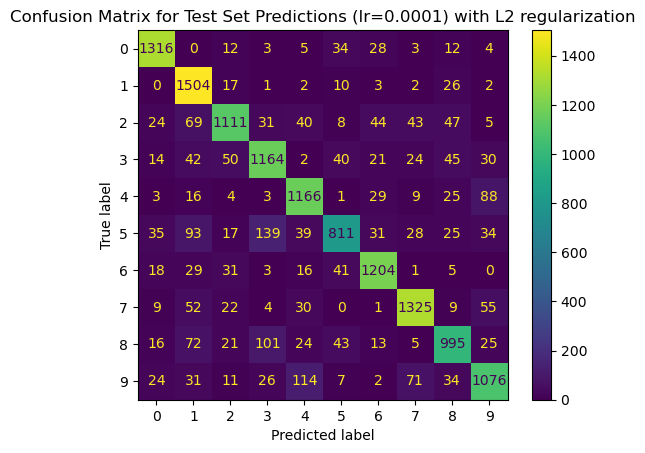

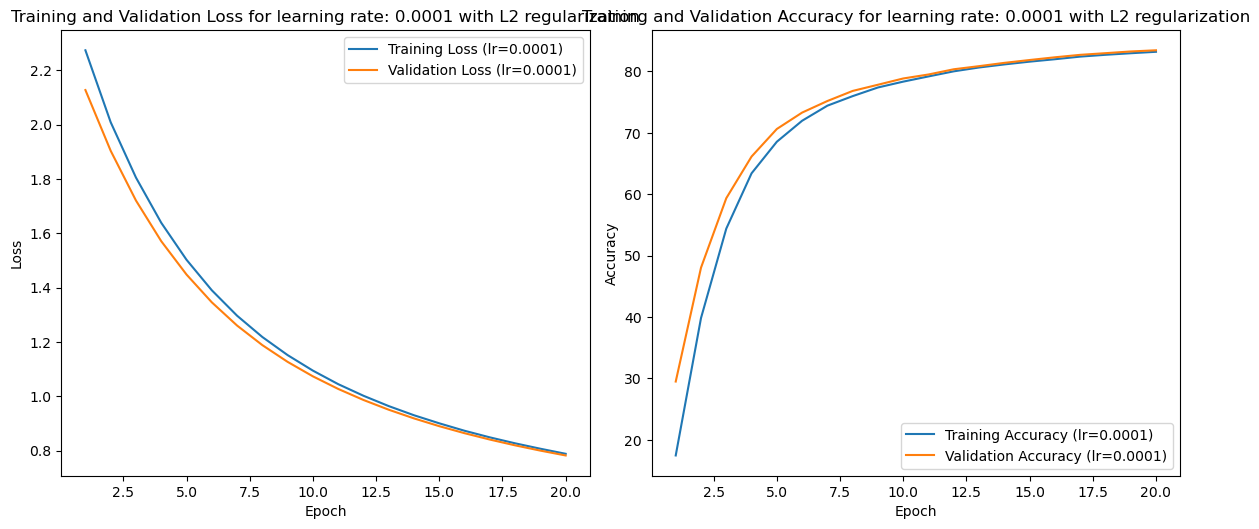

In [210]:
dict = {}
results = {}
for lr in [0.1, 0.01, 0.001, 0.0001]:
    print(f"Learning rate: {lr} with L2 regularization")
    model = SoftmaxRegressionModel(input_size, num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=l2_lambda)
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    
    start = time.time()

    for epoch in range(num_epochs):     # loop over the dataset num_epochs times
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        epoch_train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (x_train, y_train) in enumerate(train_dataset_loader):
            x_train, y_train = x_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            
            # outputs = logits = values before softmax, with shape (batch_size, num_classes)
            outputs = model(x_train)
            batch_train_loss = criterion(outputs, y_train)
            
            # calculate the gradients
            predicted = torch.argmax(outputs, dim=1)
            train_total += y_train.size(0)
            train_correct += (predicted == y_train).sum().item()
            batch_train_loss.backward()     # dl/dwi
            optimizer.step()  # update weights, W = W - lr * gradient
            epoch_train_loss += batch_train_loss.item()   # update loss of current epoch with loss for current batch
            
        # calculate the average loss and accuracy for the current epoch
        epoch_train_loss /= len(train_dataset_loader)
        train_losses.append(epoch_train_loss)
        train_accuracy = 100 * (train_correct / train_total)
        train_accuracies.append(train_accuracy)
        
        # Validation loop
        model.eval()
        epoch_val_loss = 0.0
        val_correct = 0
        val_total = 0 # total number of examples in the dataset
        
        with torch.no_grad():
            for x_val, y_val in val_dataset_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                outputs = model(x_val)
                batch_val_loss = criterion(outputs, y_val)
                epoch_val_loss += batch_val_loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += y_val.size(0)
                val_correct += (predicted == y_val).sum().item()

        epoch_val_loss /= len(val_dataset_loader)
        val_losses.append(epoch_val_loss)
        val_accuracy = 100 * (val_correct / val_total)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs} Training Loss: {epoch_train_loss:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs} Training Accuracy: {train_accuracy:.2f}%")
        print(f"Epoch {epoch+1}/{num_epochs} Validation Loss: {epoch_val_loss:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs} Validation Accuracy: {val_accuracy:.2f}%")
        print("-" * 50)
    
    end = time.time()
    total_duration = end - start
    print(f"Training time for learning rate {lr}: {total_duration:.2f} seconds with L2 regularization")

    # store the training and validation results for the current learning rate
    dict[lr] = (epoch_train_loss, train_accuracy, epoch_val_loss, val_accuracy)
    results[lr] = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'total_duration': total_duration
    }
    
    # Evaluate the model on the test dataset
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for x_test, y_test in test_dataset_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            outputs = model(x_test)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_test.cpu().numpy()) # convert to numpy array from tensor
            y_pred.extend(predicted.cpu().numpy())
    
    # calculate the test accuracy
    accuracy = accuracy_score(y_true, y_pred)
    results[lr]['test_accuracy'] = accuracy * 100
    print(f"Test Accuracy: {accuracy * 100:.2f}% for learning rate: {lr} with L2 regularization")
    print("-" * 50)
    
    print("Results Summary for learning rate: ", lr, " with L2 regularization")
    print(f"Training Loss: {dict[lr][0]: .4f}")
    print(f"Training Accuracy: {dict[lr][1]: .4f}%")
    print(f"Validation Loss: {dict[lr][2]: .4f}")
    print(f"Validation Accuracy: {dict[lr][3]: .4f}%")
    print(f"Test Accuracy: {results[lr]['test_accuracy']:.2f}%")
    print(f"Total Training Time: {results[lr]['total_duration']:.2f} seconds")
    print("-" * 50)
    
    # plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)))
    disp.plot(cmap='viridis', values_format='d')
    plt.title(f"Confusion Matrix for Test Set Predictions (lr={lr}) with L2 regularization")
    plt.show()
    
    
    # plot the training and validation loss & accuracy for the current learning rate
    plt.figure(figsize=(12, 10))
    epochs = range(1, num_epochs + 1)
    
    # plot training and validation loss
    plt.subplot(2, 2, 1)
    plt.title(f"Training and Validation Loss for learning rate: {lr} with L2 regularization")
    plt.plot(epochs, results[lr]['train_losses'], label=f'Training Loss (lr={lr})')
    plt.plot(epochs, results[lr]['val_losses'], label=f'Validation Loss (lr={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # plot training and validation accuracy
    plt.subplot(2, 2, 2)
    plt.title(f"Training and Validation Accuracy for learning rate: {lr} with L2 regularization")
    plt.plot(epochs, results[lr]['train_accuracies'], label=f'Training Accuracy (lr={lr})')
    plt.plot(epochs, results[lr]['val_accuracies'], label=f'Validation Accuracy (lr={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

<h2>Results Summary with L2 Regularization</h2>

In [211]:
print("Final Results for all learning rates with L2 Reqularization:")
for lr in [0.1, 0.01, 0.001, 0.0001]:
    print(f"learning_rate = {lr}")
    print(f"Training Loss: {dict[lr][0]: .4f}")
    print(f"Training Accuracy: {dict[lr][1]: .4f}%")
    print(f"Validation Loss: {dict[lr][2]: .4f}")
    print(f"Validation Accuracy: {dict[lr][3]: .4f}%")
    print(f"Test Accuracy: {results[lr]['test_accuracy']:.2f}%")
    print(f"Total Training Time: {results[lr]['total_duration']:.2f} seconds")

    print("-" * 50)

Final Results for all learning rates with L2 Reqularization:
learning_rate = 0.1
Training Loss:  0.2944
Training Accuracy:  91.4833%
Validation Loss:  0.3218
Validation Accuracy:  91.5000%
Test Accuracy: 91.26%
Total Training Time: 169.91 seconds
--------------------------------------------------
learning_rate = 0.01
Training Loss:  0.2789
Training Accuracy:  92.1119%
Validation Loss:  0.2960
Validation Accuracy:  91.6286%
Test Accuracy: 91.59%
Total Training Time: 179.99 seconds
--------------------------------------------------
learning_rate = 0.001
Training Loss:  0.3816
Training Accuracy:  89.5357%
Validation Loss:  0.3817
Validation Accuracy:  89.4643%
Test Accuracy: 89.32%
Total Training Time: 171.62 seconds
--------------------------------------------------
learning_rate = 0.0001
Training Loss:  0.7880
Training Accuracy:  83.2048%
Validation Loss:  0.7819
Validation Accuracy:  83.4500%
Test Accuracy: 83.37%
Total Training Time: 233.19 seconds
------------------------------------

<h2>Best Learning Rate with L2 Regularization</h2>

In [212]:
# Find the best learning rate based on the test accuracy
best_lr = None
best_accuracy = 0

for lr in results.keys():
    if results[lr]['test_accuracy'] > best_accuracy:
        best_accuracy = results[lr]['test_accuracy']
        best_lr = lr

print(f"Best Learning Rate: {best_lr} with Test Accuracy: {best_accuracy:.2f}% with L2 regularization")

Best Learning Rate: 0.01 with Test Accuracy: 91.59% with L2 regularization
